<a href="https://colab.research.google.com/github/iSS1337/CV1_Laboratory/blob/main/CV1_Laboratory_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# MASTER PLAN
# Importam datele                               Done
# Verificarea Integritatii datelor              Done
# Impartirea datelor in Train Test [Val]        Done
# Preprocesarea Datelor:                        Done
#   * Normalizarea si augumentarea datelor [D]  Done
#   * Analiza datelor                           Done
#   * Resize                                    Done
#   * Hand segmentation                         Done
#   * Hand extraction                           Done
# Extragem trasaturile                          Done
# Clasificare                                   Done
# PR curve / Matricea de confuzie               Done

In [2]:
#   Matrice de confuzie pentru un clasificator binar
#
#               1   |  0
#   pred T    100 % |   0
#           ________|_________
#   pred N     0    |  100%
#                   |


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
bp = "/content/drive/MyDrive/drive/"

file_path_arr = []
for i in range(4):
  file_path_arr.append(glob(bp+str(i)+"/*.jpg"))
print(len(file_path_arr))
print(file_path_arr)
print(np.shape(file_path_arr))

4
[['/content/drive/MyDrive/drive/0/9.jpg', '/content/drive/MyDrive/drive/0/8.jpg', '/content/drive/MyDrive/drive/0/3.jpg', '/content/drive/MyDrive/drive/0/2.jpg', '/content/drive/MyDrive/drive/0/6.jpg', '/content/drive/MyDrive/drive/0/4.jpg', '/content/drive/MyDrive/drive/0/5.jpg', '/content/drive/MyDrive/drive/0/7.jpg', '/content/drive/MyDrive/drive/0/0.jpg', '/content/drive/MyDrive/drive/0/1.jpg'], ['/content/drive/MyDrive/drive/1/3.jpg', '/content/drive/MyDrive/drive/1/1.jpg', '/content/drive/MyDrive/drive/1/6.jpg', '/content/drive/MyDrive/drive/1/8.jpg', '/content/drive/MyDrive/drive/1/9.jpg', '/content/drive/MyDrive/drive/1/4.jpg', '/content/drive/MyDrive/drive/1/5.jpg', '/content/drive/MyDrive/drive/1/2.jpg', '/content/drive/MyDrive/drive/1/0.jpg', '/content/drive/MyDrive/drive/1/7.jpg'], ['/content/drive/MyDrive/drive/2/1.jpg', '/content/drive/MyDrive/drive/2/5.jpg', '/content/drive/MyDrive/drive/2/2.jpg', '/content/drive/MyDrive/drive/2/0.jpg', '/content/drive/MyDrive/drive/2/

In [11]:
random.seed(42)

In [12]:
image_index_arr = random.sample(range(0,9),7)
print(image_index_arr)

[1, 0, 5, 2, 8, 4, 7]


In [13]:
train_image_path = []
test_image_path = []

for hand_class in file_path_arr:
  tmp_train = []
  tmp_test = []
  for i in range(10):
    if i not in image_index_arr:
      tmp_test.append(hand_class[i])
    else:
      tmp_train.append(hand_class[i])
  train_image_path.append(tmp_train)
  test_image_path.append(tmp_test)
print(np.shape(train_image_path))
print(np.shape(test_image_path))

(4, 7)
(4, 3)


In [14]:
train_images = []
test_images = []

for cls in train_image_path:
  t = []
  for i in cls:
    t.append(cv2.imread(i))
  train_images.append(t)

for cls in test_image_path:
  t = []
  for i in cls:
    t.append(cv2.imread(i))
  test_images.append(t)

print(np.shape(train_images))
print(np.shape(test_images))

(4, 7, 4032, 1908, 3)
(4, 3, 4032, 1908, 3)


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x79a9ea712990>)

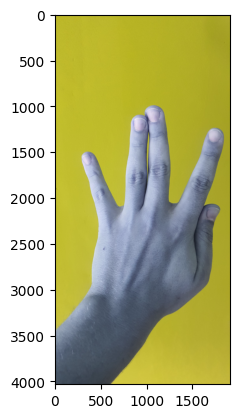

In [15]:
plt.figure(), plt.imshow(train_images[0][0])

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x79a9ea35bb60>)

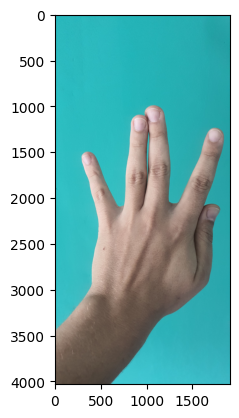

In [16]:
im = train_images[0][0]
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(), plt.imshow(img_rgb)

In [17]:
print(np.shape(img_rgb))

(4032, 1908, 3)


In [18]:
# RESIZE ALL
# CONVERT TO CORRECT COLOR SPACE

In [19]:
def resize_and_covert(image, scale_factor = 10):
  w, h, _ = np.shape(image)
  im_resized = cv2.resize(image, (int(h/scale_factor), int(w/scale_factor)))
  img_rgb = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)
  return img_rgb


In [20]:
for i,cls in enumerate(train_images):
  for j,im in enumerate(cls):
    train_images[i][j] = resize_and_covert(im)

for i,cls in enumerate(test_images):
  for j,im in enumerate(cls):
    test_images[i][j] = resize_and_covert(im)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x79a9ea3abef0>)

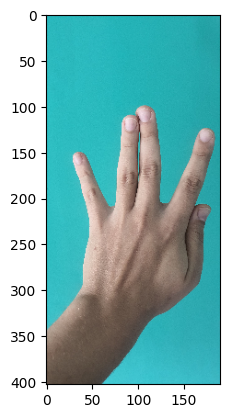

In [21]:
plt.figure(), plt.imshow(train_images[0][0])

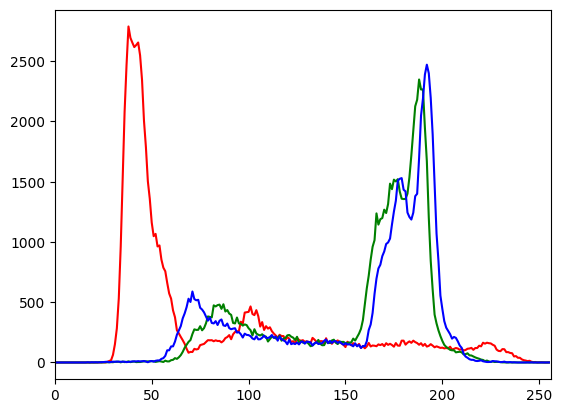

In [22]:
img = train_images[0][0]
rgb = ['r', 'g', 'b']

for i, color in enumerate(rgb):
  hist = cv2.calcHist([img], [i], None, [256], [0,256])
  plt.plot(hist, color=color)
  plt.xlim([0, 256])
plt.show()

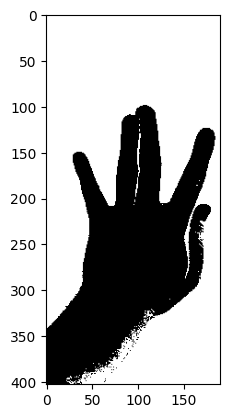

In [23]:
red = img[:, :, 0].copy()
red[red > 80] = 0
red[red > 0] = 255
plt.imshow(red, cmap='grey')

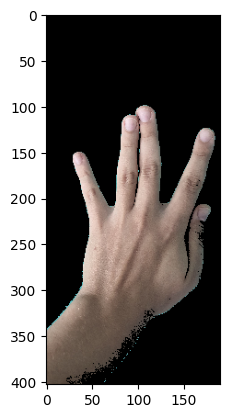

In [24]:
im = img.copy()
im[red == 255] = [0, 0 , 0]
plt.imshow(im)

In [25]:
def binarizare(img):
    R = img[:, :, 0]
    G = img[: ,:, 1]
    B = img[:, :, 2]
    C1 = np.zeros((img.shape[0], img.shape[1]))
    C2 = np.zeros((img.shape[0], img.shape[1]))
    C3 = np.zeros((img.shape[0], img.shape[1]))
    C4 = np.zeros((img.shape[0], img.shape[1]))
    C5 = np.zeros((img.shape[0], img.shape[1]))
    C6 = np.zeros((img.shape[0], img.shape[1]))
    C7 = np.zeros((img.shape[0], img.shape[1]))
    rez = np.zeros((img.shape[0], img.shape[1]))
    C1[np.logical_and(R > 95, G > 40, B > 20)] = 1
    C2[(np.maximum(np.maximum(R, G), B) - np.minimum(np.minimum(R, G), B)) > 15] = 1
    C3[np.absolute(R - G) > 15] = 1
    C4[np.logical_and(R > G, R > B)] = 1
    C5[np.logical_and(R > 220, G > 210, B > 170)] = 1
    C6[np.absolute(R - G) <= 15] = 1
    C7[np.logical_and(R > B, G > B)] = 1

    caz1 = np.logical_and(np.logical_and(C1 == 1, C2 == 1, C3 == 1), C4 == 1)
    caz2 = np.logical_and(C5 ==1, C6 == 1, C7 == 1)
    rez[np.logical_or(caz1 == 1, caz2 == 1)] = 1
    return rez

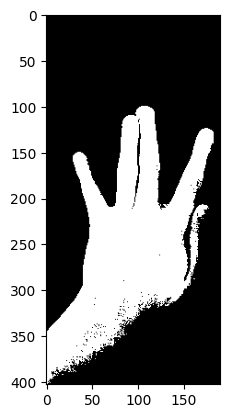

In [26]:
bin = binarizare(img)
plt.imshow(bin, cmap='grey')

In [27]:
train_images_bin = []
test_images_bin = []

for cls in train_images:
  t = []
  for i in cls:
    t.append(binarizare(i))
  train_images_bin.append(t)

for cls in test_images:
  t = []
  for i in cls:
    t.append(binarizare(i))
  test_images_bin.append(t)

In [28]:
def background(img):
  red = img[:, :, 0]
  red[red > 80] = 0
  red[red > 0] = 255
  img[red == 255] = [0, 0 , 0]
  return img

In [29]:
train_images_back = []
test_images_back = []

for cls in train_images:
  t = []
  for i in cls:
    t.append(background(i))
  train_images_back.append(t)

for cls in test_images:
  t = []
  for i in cls:
    t.append(background(i))
  test_images_back.append(t)

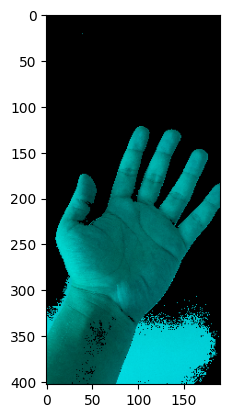

In [30]:
for cls in train_images_back:
  for i in cls:
    plt.imshow(i)


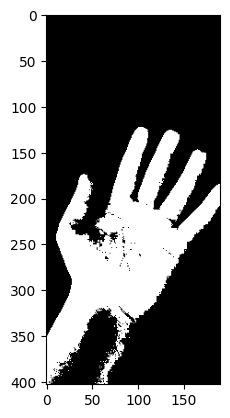

In [31]:
for cls in train_images_bin:
  for i in cls:
    plt.imshow(i, cmap='grey')


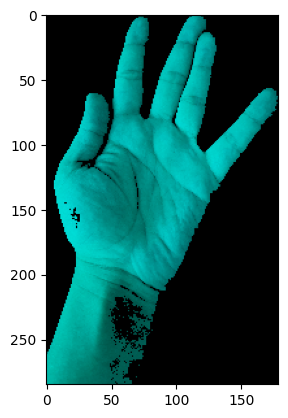

In [32]:
def find_contours(img):
  contours, hierarchy = cv2.findContours(img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  # print(len(contours))

  max = -1
  idx = -1
  maxRect = np.array([0, 0, 0, 0])
  for i, c in enumerate(contours):
    bbox = cv2.boundingRect(c)
    arie = bbox[2] * bbox[3]

    if arie > max:
      max = arie
      maxRect = bbox
      idx = i
  return maxRect

def crop_image(img, img_bw):
  maxRect = find_contours(img_bw)
  crop_bw = img_bw[maxRect[1] : maxRect[1] + maxRect[3], maxRect[0] : maxRect[0] + maxRect[2]]
  crop    = img[maxRect[1] : maxRect[1] + maxRect[3], maxRect[0] : maxRect[0] + maxRect[2]]
  crop[crop_bw == 0] = [0, 0, 0]
  return crop

im1 = crop_image(train_images[0][5], train_images_bin[0][5])
plt.imshow(im1)



In [33]:
import numpy as np
import random
import cv2
from matplotlib import pyplot as plt

def sp_noise_efficient(image, prob):
    '''
    prob: Probabilitatea TOTALĂ de zgomot
    '''
    # 1. Pornește de la o COPIE, nu de la zero.
    output = np.copy(image)
    thres = 1 - prob # Pragul pentru a PĂSTRA pixelul

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()

            # Verifici doar dacă trebuie să adaugi zgomot
            if rdn >= thres: # (Sau, echivalent: 'if rdn < prob')
                # Pixelul ăsta (ex: 10% din ei) e cu zgomot.
                # Acum decide 50/50 dacă e salt sau pepper.
                if random.random() < 0.5:
                    output[i][j] = 0  # Pepper
                else:
                    output[i][j] = 255 # Salt

            # else:
                # Nu faci nimic. Pixelul e deja corect din np.copy()

    return output

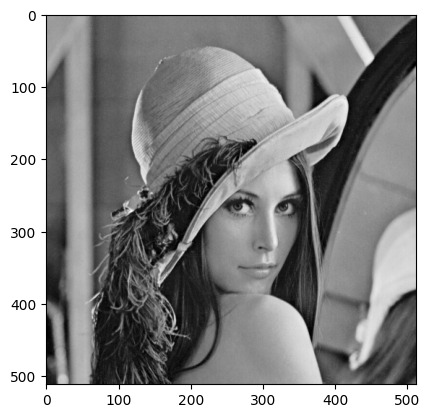

In [47]:
img_path = "/content/drive/MyDrive/drive/lenna/lenna.png"
img = cv2.imread(img_path, 0)
plt.imshow(img, cmap = 'gray')

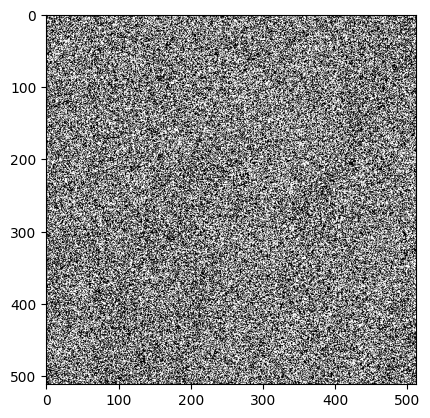

In [48]:

noisy_image = sp_noise_efficient(img,0.9)
plt.imshow(noisy_image, cmap = 'gray')

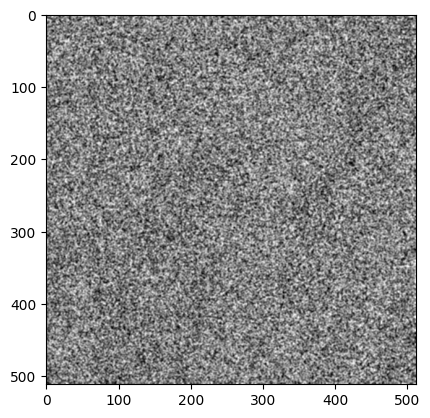

In [49]:

kernel = np.ones((3,3),np.float32)/9
dst = cv2.filter2D(noisy_image,-1,kernel)
plt.imshow(dst, cmap = 'gray')


In [50]:

def filtru_siva(img_in,dim):
  img= img_in.copy()

  for i in range(dim,img.shape[0]-dim):
        for j in range(dim,img.shape[1]-dim):
          if img_in[i,j] != 0 and img_in[i,j] != 255:
            continue
          t = img_in[i-int(dim):i+int(dim),j-int(dim):j+int(dim)]
          ar = np.array(t).flatten()
          # ar = t.reshape(-1)
          ar_sort = np.sort(ar)

          img[i,j] = ar_sort[int(len(ar)/2)]
  return img


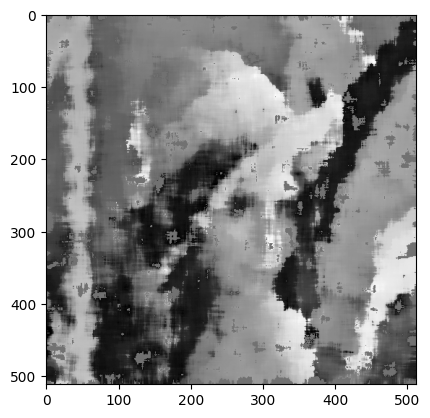

In [51]:

 dst = cv2.medianBlur(noisy_image, 21)
 dst[dst == 0 ] = 127
 dst[dst == 255 ] = 127
 plt.imshow(dst, cmap = 'gray')

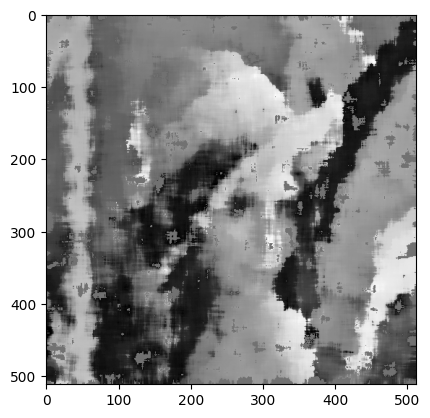

In [52]:
dst = cv2.medianBlur(noisy_image, 21)
dst[dst == 0 ] = 127
dst[dst == 255 ] = 127
plt.imshow(dst, cmap = 'gray')

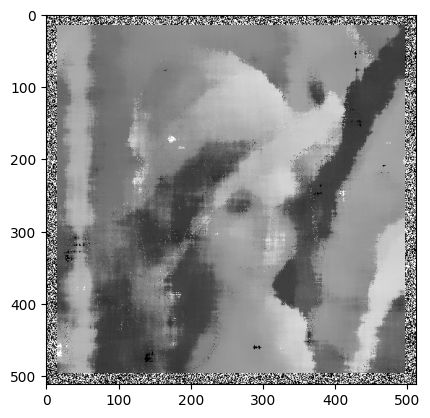

In [53]:

dst = filtru_siva(noisy_image, 15)
plt.imshow(dst, cmap = 'gray')


In [54]:
height = 128
width = 64
winSize = (16,16)
blockSize = (16,16)
blockStride = (16,16)
cellSize = (16,16)
nbins = 9
rprm = -1
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
rndp = 32
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

im_resized = cv2.resize(im1, (width, height))
descriptor = hog.compute(im_resized)
# print(np.shape(descriptor))
features=[]
labels = []
for index, cls in enumerate(train_images):
  for index2, i in enumerate(cls):
    cropped_image = crop_image(i, train_images_bin[index][index2])
    resized_cropped_image = cv2.resize(cropped_image, (width, height))
    features.append(hog.compute(resized_cropped_image))
    labels.append(index)

print(labels)




[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3]


In [55]:
data = np.float32(features)
data_labels = np.float32(labels)
knn = cv2.ml.KNearest_create()
knn.train(data, cv2.ml.ROW_SAMPLE, data_labels)
test = data[0]
test = test.reshape(1,len(test))
rezultat=knn.findNearest(np.float32(test), 3)
print(rezultat)

(0.0, array([[0.]], dtype=float32), array([[0., 1., 3.]], dtype=float32), array([[0.      , 7.462479, 7.702948]], dtype=float32))


In [56]:
SVM = cv2.ml.SVM_create()
SVM.setKernel(cv2.ml.SVM_LINEAR)
label = np.int32(labels)
SVM.train(data, cv2.ml.ROW_SAMPLE, label)
result = SVM.predict(test)
print(result)

# de extras trasaturi pentru date de testare
# de rulat testele pentru setul de date
# matrice de confuzie


(0.0, array([[0.]], dtype=float32))


In [58]:
winSize = (64, 64)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

data_train = []
labels_train = []
data_test = []
labels_test = []

# Procesare set antrenare
for i, hand_class in enumerate(train_images):
    for img in hand_class:
        if img is not None:

            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            res = cv2.resize(img, winSize)


            hog_features = hog.compute(res)


            data_train.append(hog_features.flatten())
            labels_train.append(i)


for i, hand_class in enumerate(test_images):
    for img in hand_class:
        if img is not None:
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            res = cv2.resize(img, winSize)


            hog_features = hog.compute(res)

            data_test.append(hog_features.flatten())
            labels_test.append(i)


data_train = np.array(data_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.int32)
data_test = np.array(data_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.int32)

print(f"Noua forma a datelor (trasaturi HOG): {data_train.shape}")

Noua forma a datelor (trasaturi HOG): (28, 1764)


In [59]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.train(data_train, cv2.ml.ROW_SAMPLE, labels_train)


_, y_pred = svm.predict(data_test)


y_pred = y_pred.flatten().astype(int)

<Figure size 800x600 with 0 Axes>

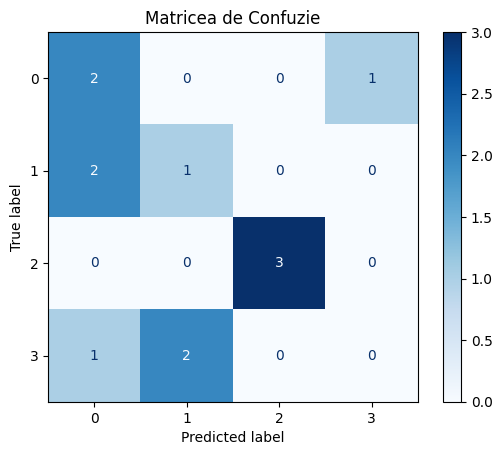

Acuratetea pe setul de test: 50.00%


In [61]:
cm = confusion_matrix(labels_test, y_pred)


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1', '2', '3'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matricea de Confuzie')
plt.show()


accuracy = np.mean(y_pred == labels_test) * 100
print(f"Acuratetea pe setul de test: {accuracy:.2f}%")

In [62]:

k = 4

knn = cv2.ml.KNearest_create()

knn.train(data_train, cv2.ml.ROW_SAMPLE, labels_train.astype(np.float32))

ret, results, neighbors, dist = knn.findNearest(data_test, k=k)


y_pred_knn = results.flatten().astype(int)

<Figure size 800x600 with 0 Axes>

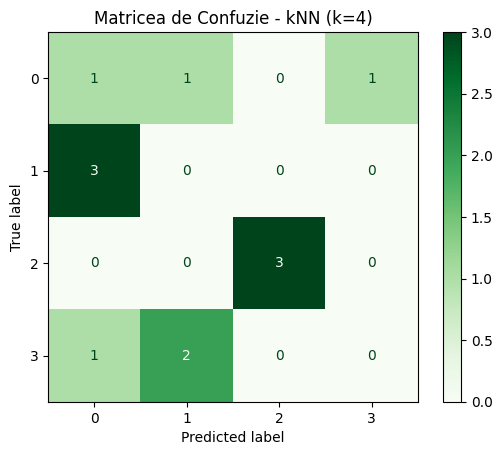

Raport de clasificare kNN:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         3

    accuracy                           0.33        12
   macro avg       0.30      0.33      0.31        12
weighted avg       0.30      0.33      0.31        12



In [63]:
cm_knn = confusion_matrix(labels_test, y_pred_knn)


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['0', '1', '2', '3'])
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Matricea de Confuzie - kNN (k={k})')
plt.show()


print("Raport de clasificare kNN:")
print(classification_report(labels_test, y_pred_knn))